## Imports

In [4]:
import argparse
import logging
import os
import torch

import numpy as np
from datasets import load_from_disk
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    BitsAndBytesConfig,
    AutoModel,
    AutoConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


## Set up CometKiwi base model

In [5]:
from comet import download_model, load_from_checkpoint

# Import CometKiwi Model
model_path = download_model("Unbabel/wmt22-cometkiwi-da")
model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
print_trainable_parameters(model)

trainable params: 6296603 || all params: 565137435 || trainable%: 1.114171988978221


## Finetuning Multilingual Uncased Bert Model

In [7]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

train_dataset = pd.read_csv('train.csv')
#train_dataset = train_dataset.iloc[:6992] # EN to DE
train_dataset = train_dataset.iloc[6992:13964] # EN to ZH
#train_dataset = train_dataset.iloc[13964:20960] # ET to EN
#train_dataset = train_dataset.iloc[20960:27124] # NP to EN
#train_dataset = train_dataset.iloc[27124:33898] # RO to EN
#train_dataset = train_dataset.iloc[33898:] # RU to EN
train_dataset = Dataset.from_pandas(train_dataset)

validation_dataset = pd.read_csv('validation.csv')
#validation_dataset = validation_dataset.iloc[:1000] # EN to DE
validation_dataset = validation_dataset.iloc[1000:1996] # EN to ZH
#validation_dataset = validation_dataset.iloc[1996:2995] # ET to EN
#validation_dataset = validation_dataset.iloc[2995:3937] # NP to EN
#validation_dataset = validation_dataset.iloc[3937:4842] # RO to EN
#validation_dataset = validation_dataset.iloc[4842:] # RU to EN
validation_dataset = Dataset.from_pandas(validation_dataset)

test_dataset = pd.read_csv('test.csv')
#test_dataset = test_dataset.iloc[:998] # EN to DE
test_dataset = test_dataset.iloc[998:1995] # EN to ZH
#test_dataset = test_dataset.iloc[1995:2994] # ET to EN
#test_dataset = test_dataset.iloc[2994:3993] # NP to EN
#test_dataset = test_dataset.iloc[3993:4993] # RO to EN
#test_dataset = test_dataset.iloc[4993:] # RU to EN
test_dataset = Dataset.from_pandas(test_dataset)

### Tokenize Dataloaders

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["original"], 
        examples["translation"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
print('Vocab size: ',tokenizer.vocab_size)

Map:   0%|          | 0/6972 [00:00<?, ? examples/s]

Map:   0%|          | 0/996 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Vocab size:  105879


In [9]:
# Remove irrelvant columns
train_dataset = train_dataset.remove_columns(['Unnamed: 0','original','translation'])
validation_dataset = validation_dataset.remove_columns(['Unnamed: 0','original','translation'])
test_dataset = test_dataset.remove_columns(['Unnamed: 0','original','translation'])

# Rename column names to correct format
train_dataset = train_dataset.rename_column("mean", "labels")
validation_dataset = validation_dataset.rename_column("mean", "labels")
test_dataset = test_dataset.rename_column("mean", "labels")

# Format lists to torch tensors
train_dataset.set_format("torch")
validation_dataset.set_format("torch")
test_dataset.set_format("torch")

In [10]:
# small subset of entire training data for testing the training process

train_dataset = train_dataset.shuffle(seed=42).select(range(1000))
validation_dataset = validation_dataset.shuffle(seed=42).select(range(100))
test_dataset = test_dataset.shuffle(seed=42).select(range(100))

### Create Torch Dataloaders

In [11]:
from torch.utils.data import DataLoader
batch_size = 16

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

### Load Bert Model

In [13]:
from transformers import AutoModelForSequenceClassification

# download and quantize model from model hub
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

#bert_model = torch.load("finetuned_Bert.pth", weights_only=False)
bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1, quantization_config=bnb_config)
print_trainable_parameters(bert_model)


model.gradient_checkpointing_enable()

model = get_peft_model(model, config)

# ADDS Q
bert_model = prepare_model_for_kbit_training(bert_model)

# ADDS LORA
config = LoraConfig(
        r=16, 
        target_modules = ['query','key','value'],
        inference_mode=False
    )

bert_model = get_peft_model(bert_model, config)
print_trainable_parameters(bert_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 167357185 || all params: 167357185 || trainable%: 100.0
trainable params: 884736 || all params: 168241921 || trainable%: 0.5258713136067913


In [14]:
from torch.optim import AdamW

optimizer = AdamW(bert_model.parameters(), lr=1e-4)

In [15]:
from transformers import get_scheduler

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [16]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert_model.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


PeftModel(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(105879, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16,

In [17]:
from tqdm.auto import tqdm
import csv

with open('log.csv', 'w', newline='') as f:
   writer = csv.writer(f)
   writer.writerow(['epoch', 'train_loss', 'valid_loss'])

for epoch in range(num_epochs):
    train_losses = []
    valid_losses = []
    
    bert_model.train()
    progress_bar = tqdm(range(len(train_dataloader)+len(eval_dataloader)))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = bert_model(**batch)
        loss = outputs.loss
        train_losses.append(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    bert_model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bert_model(**batch)
            loss = outputs.loss
            valid_losses.append(loss)
            progress_bar.update(1)
            
    train_loss = sum(train_losses)/len(train_losses)
    valid_loss = sum(valid_losses)/len(valid_losses)
    print(f'epoch {epoch+1}: training loss: {train_loss} validation loss: {valid_loss}')
    with open('log.csv', 'a', newline='') as f:
       writer = csv.writer(f)
       writer.writerow([epoch+1, train_loss.item(), valid_loss.item()])
        

  0%|          | 0/70 [00:00<?, ?it/s]

epoch 1: training loss: 5119.20556640625 validation loss: 4251.1865234375


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 2: training loss: 5015.9140625 validation loss: 4193.72265625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 3: training loss: 5004.3671875 validation loss: 4192.64501953125


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 4: training loss: 5010.97998046875 validation loss: 4191.9736328125


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 5: training loss: 5014.779296875 validation loss: 4190.8212890625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 6: training loss: 4948.119140625 validation loss: 4016.549560546875


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 7: training loss: 4822.77685546875 validation loss: 3953.7822265625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 8: training loss: 4770.65966796875 validation loss: 3923.042236328125


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 9: training loss: 4736.46240234375 validation loss: 3906.328857421875


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 10: training loss: 4730.66162109375 validation loss: 3895.517578125


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 11: training loss: 4725.4208984375 validation loss: 3888.43603515625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 12: training loss: 4723.67724609375 validation loss: 3883.393310546875


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 13: training loss: 4715.94921875 validation loss: 3879.818359375


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 14: training loss: 4716.5419921875 validation loss: 3877.00390625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 15: training loss: 4698.2421875 validation loss: 3874.979736328125


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 16: training loss: 4704.70751953125 validation loss: 3873.22998046875


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 17: training loss: 4696.42724609375 validation loss: 3872.2490234375


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 18: training loss: 4696.96826171875 validation loss: 3871.3447265625


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 19: training loss: 4695.05517578125 validation loss: 3871.088623046875


  0%|          | 0/70 [00:00<?, ?it/s]

epoch 20: training loss: 4702.787109375 validation loss: 3870.87158203125


In [21]:
# save model
torch.save(bert_model, 'Bert_QLoRA_EN_ZH.pth')

### Plot train and validation loss graph

<Axes: >

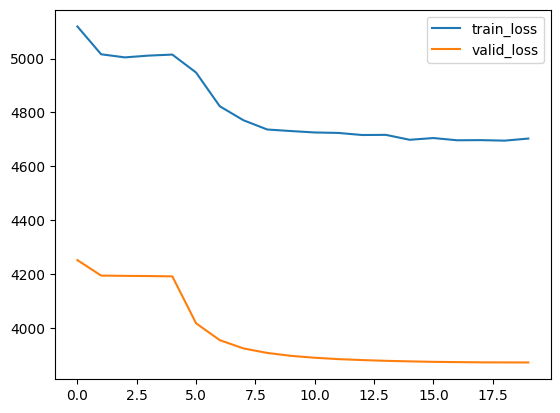

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
train_log = pd.read_csv('log.csv')
train_log = train_log[['train_loss','valid_loss']]
train_log.plot()

## Set up data for predictions

In [6]:
import pandas as pd

mt_path = 'test_data_2023/task1_sentence_level/en-de/test.ende.final.mt'
src_path = 'test_data_2023/task1_sentence_level/en-de/test.ende.final.src'
with open(mt_path, 'r') as f:
    mt = f.read().splitlines()
    f.close()
with open(mt_path, 'r') as f:
    src = f.read().splitlines()
    f.close

data = []
if len(mt) == len(src):
    for (m,s) in list(zip(mt,src)):
        d = {}
        d['mt'] = m
        d['src'] = s
        data.append(d)
else:
    print('length of mt and src do not match')

In [9]:
base_model_output = model.predict(data, batch_size=8, gpus=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 19.94it/s]


In [ ]:
base_model_output

## Apply LoRa to model

In [11]:
lora_model = prepare_model_for_kbit_training(model)

In [14]:
config = LoraConfig(
        r=16, 
        target_modules = ['query','key','value']
    )

lora_model = get_peft_model(lora_model, config)

In [15]:
print_trainable_parameters(lora_model)

trainable params: 2359296 || all params: 567496731 || trainable%: 0.4157373727673508


In [16]:
lora_model_output = model.predict(data, batch_size=8, gpus=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 238/238 [00:12<00:00, 18.80it/s]


In [22]:
diff_sum = 0
for (b,l) in list(zip(base_model_output['scores'], lora_model_output['scores'])):
    diff_sum += (b-l)
diff_sum

0.0

{'labels': tensor([13.6667, 70.0000, 36.0000, 85.0000, 89.0000, 91.6667, 72.6667, 81.6667]),
 'input_ids': tensor([[  101, 25577, 12123,  ...,     0,     0,     0],
         [  101, 10103, 69387,  ...,     0,     0,     0],
         [  101, 38544, 66554,  ...,     0,     0,     0],
         ...,
         [  101, 24079, 13384,  ...,     0,     0,     0],
         [  101, 10572, 11120,  ...,     0,     0,     0],
         [  101, 10597, 54475,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

,Unnamed: 0,original,translation,mean
4993,5000,"Этот молодой мозамбикец учился в России, а чле...","This young Mozambican studied in Russia, and m...",90.000000
4994,5001,Ласковое слово лучше мягкого пирога.,An affectionate word is better than a soft pie.,82.333333
4995,5002,"— Ну, спасибо, конечно, на добром слове...","Well, thanks, of course, for the kind words...",74.000000
4996,5003,Вэтом ейпомогает Дмитрий Рыжов.,Dmitry Ryzhov helps in this.,83.000000
4997,5004,"Приплюсуй к цене проезда такой набор бонусов, ...","Add to the fare such a set of bonuses, and it ...",81.000000
...,...,...,...,...
5988,5995,"За морем веселье, да чужое, а у нас и горе, да...","Beyond the sea is merriment, but we have sorro...",26.333333
5989,5996,С 1991 управляет крупнейшим на сегодняшний ден...,"Since 1991, he has managed the largest nunnery...",68.666667
5990,5997,"Борода-то с ворота, а ума-то с прикалиток.","The beard is from the gate, and the mind is fr...",16.333333
5991,5998,"Шри Япутра поднялся на трибуну, обвел всех взг...","Sri Yaputra rose to the podium, looked around,...",81.000000


In [171]:
validation_dataset = pd.read_csv('validation.csv')
validation_dataset.iloc[:1000] # EN to DE
validation_dataset.iloc[1000:1996] # EN to ZH
validation_dataset.iloc[1996:2995] # EN to ET
validation_dataset.iloc[2995:3937] # EN to NP
validation_dataset.iloc[3937:4842] # EN to RO
validation_dataset.iloc[4842:] # EN to RU

,Unnamed: 0,original,translation,mean
4842,4847,"Кто бы и знал, коли б не сам сказал.",Who would have known if he hadn't said it hims...,90.000000
4843,4848,"Которая рука крест кладёт, та и нож точит.",Whoever puts the cross in his hand sharpens th...,39.333333
4844,4849,Иисус им в ответ:,Jesus answered them:,89.666667
4845,4850,"Это уже третий случай, когда подобные действия...",This is the third time such actions by Hong Ko...,88.666667
4846,4851,Официальное заявление u/Forjoin в коллегию мод...,The official u / Forjoin statement to the r / ...,89.666667
...,...,...,...,...
5837,5842,«Потери не просто велики — они ужасающи.,The losses are not just large; they are horrific.,85.000000
5838,5843,РЕВПАНОРАМА - пУТИН БАНДИТ ИЗ 90-Х ::,REVPANORAMA - PUTIN BANDIT FROM the 90's::,70.333333
5839,5844,Интервью с А.Трефиловой,Interview with A. Trefilova,96.000000
5840,5845,"Во что свинья ни оденется, а всё хвост к гузну...","Whatever the pig puts on, the whole tail will ...",64.000000


In [18]:
test_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})